In [165]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
from catboost import CatBoostClassifier

#инструменты подготовки данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

#метрики
from sklearn.metrics import recall_score, precision_score, accuracy_score

#для пайплайна
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# для автоподбора гиперпараметров
#from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#для работы с пропусками
#from sklearn.impute import SimpleImputer

#для анализа корреляции
import phik

#для выгрузки
import pickle

#константы
RANDOM_STATE = 42
TEST_SIZE = 0.25


In [167]:
!pip install phik

<h2> Описание тестового датасета </h2>

In [168]:
#загрузка данных
#первичное знакомство с файлами показало, что данные в датасете разделены различными знаками;
df = pd.read_csv('heart_train.csv', sep=',')
df_test = pd.read_csv('heart_test.csv', sep=',')

In [169]:
# функция для первичного анализа датасета
def short_describe(data):
    print('Основная статистика')
    display(data.info())
    
    print('Первые 5 строк датасета')
    display(data.head(5))
    
    print('Первичная статистика по числовым данным')
    display(data.describe())
    
    print('Количество дубликатов в датасете', data.duplicated().sum())
    
    
    nan_sum = pd.DataFrame(data.isna().sum(), columns=['количество пропусков'])
    nan_percent =pd.DataFrame(data.isna().mean()*100, columns=['Доля пропусков'])
    
    display(pd.concat([nan_sum, nan_percent], axis=1))

    return
    

In [170]:
pd.set_option('display.max_columns', None)

In [171]:
print('Датасет тренировочная выборка')
short_describe(df)

Датасет тренировочная выборка
Основная статистика
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems         

None

Первые 5 строк датасета


,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


Первичная статистика по числовым данным


,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Systolic blood pressure,Diastolic blood pressure,id
count,8685.000000,8685.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000
mean,4342.000000,0.449958,0.501070,0.050658,0.652097,0.489576,0.902867,0.498342,0.601990,0.503378,1.057455,0.495380,0.501185,5.493367,0.499164,0.496055,0.496774,0.505484,3.508292,0.503737,0.346920,0.227339,0.048159,0.036689,0.450295,0.497634,4831.210823
std,2507.287877,0.231174,0.284716,0.023453,0.476333,0.499921,0.296157,0.500027,0.489517,0.284810,0.866645,0.500008,0.500028,2.867862,0.285340,0.284698,0.282561,0.286320,2.281772,0.328061,0.476017,0.076635,0.075531,0.060157,0.170184,0.171830,2782.585625
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2171.000000,0.258427,0.267857,0.034830,0.000000,0.000000,1.000000,0.000000,0.000000,0.263286,0.000000,0.000000,0.000000,3.000000,0.255875,0.251922,0.254190,0.263636,2.000000,0.166667,0.000000,0.227018,0.048229,0.036512,0.303226,0.348837,2425.000000
50%,4342.000000,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,0.000000,1.000000,0.502110,1.000000,0.000000,1.000000,5.000000,0.499920,0.494889,0.494774,0.503603,3.000000,0.500000,0.000000,0.227018,0.048229,0.036512,0.445161,0.500000,4837.000000
75%,6513.000000,0.640449,0.746429,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.748709,2.000000,1.000000,1.000000,8.000000,0.744623,0.741036,0.736974,0.750649,6.000000,0.833333,1.000000,0.227018,0.048229,0.036512,0.600000,0.651163,7242.000000
max,8684.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,10.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9650.000000


Количество дубликатов в датасете 0


,количество пропусков,Доля пропусков
Unnamed: 0,0,0.000000
Age,0,0.000000
Cholesterol,0,0.000000
Heart rate,0,0.000000
Diabetes,243,2.797927
Family History,243,2.797927
Smoking,243,2.797927
Obesity,243,2.797927
Alcohol Consumption,243,2.797927
Exercise Hours Per Week,0,0.000000


In [172]:
columns_na = ['Diabetes', 'Family History', 'Smoking', 'Obesity',
                   'Alcohol Consumption', 'Previous Heart Problems',
                   'Medication Use', 'Stress Level', 'Physical Activity Days Per Week']

In [173]:
#Проверка совпадают ли записи с пропусками
null_correlation = df[columns_na].isnull().corr()
print("\nКорреляция пропусков между столбцами:")
display(null_correlation)


Корреляция пропусков между столбцами:


,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Previous Heart Problems,Medication Use,Stress Level,Physical Activity Days Per Week
Diabetes,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Family History,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Smoking,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Obesity,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Alcohol Consumption,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Previous Heart Problems,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Medication Use,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Stress Level,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Physical Activity Days Per Week,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [174]:
#отложили проблемные записи в отдельный датасет
df_na = df[df[columns_na].isna().any(axis=1)]


Датасет для обучения содержит 8685 записей. Дубликаты остутствуют
Датасет содержит 243 пропуска в одних и тех же записях в столбцах: Diabetes, Family History, Smoking, Obesity, Alcohol Consumption, Previous Heart Problems, Medication Use, Stress Level, Physical Activity Days Per Week. работа с ними будет проведена отдельно

Целевой признак Heart Attack Risk — риск возникновения инфаркта (бинарный признак)


Записи имеют не только id, но и дублирующий столбец с нумерацией (также подлежит удалению)

**Группа нормализованных признаков**
Часть признаков уже нормализована (значения находятся в диапазоне от 0 до 1)

*Основные физиологические признаки пациента*
* Age (Возраст) – нормализованный возраст пациента
* BMI (Индекс массы тела) – ИМТ.

*Социальные признаки пациента (образ жизни)*

* Income (Доход) – уровень дохода.

* Exercise Hours Per Week (Часы физической активности в неделю) – активность.
* Sedentary Hours Per Day (Часы сидячего образа жизни в день) – малоподвижность.
* Sleep Hours Per Day (Часы сна в день) – продолжительность сна.


*Группа признаков анализов пациента*

* Cholesterol (Холестерин) – уровень холестерина. Высокий холестерин связан с повышенным риском сердечных заболеваний.
* Triglycerides (Триглицериды) – уровень триглицеридов.
* Blood sugar (Уровень сахара в крови) – глюкоза.
* CK-MB (Креатинкиназа-MB) – маркер повреждения сердца.
* Troponin (Тропонин) – маркер инфаркта.

*Группа признаков сердечно-сосудистые показатели*
* Heart rate (Частота сердечных сокращений) – ЧСС.Аномальные значения могут указывать на проблемы с сердцем.
* Systolic blood pressure (Систолическое давление) – верхнее давление. Высокое давление увеличивает риск болезней сердца.
* Diastolic blood pressure (Диастолическое давление) – нижнее давление.

**Числовые признаки**
* Stress Level (Уровень стресса). Числовой признак (значения от 1 до 10). Может быть преобразован в категориальный.
* Physical Activity Days Per Week (Дни физической активности в неделю). Числовой признак (значения от 0 до 7).

**Часть признаков категориальны, некоторые бинарны**

*Категориальные признаки*

* Gender - пол пациента с 2-мя значениями: Male/Female. Может быть преобразован в бинарный признак. 
* Diet (Диета).Категориальный признак (0, 1, 2, 3).Тип питания пациента.

*Бинарные признаки*

* Diabetes - наличие диабета. Диабет является значимым фактором риска.

* Family History - наличие сердечных заболеваний у родственников.Если у человека есть родитель или брат, страдающий от сердечного приступа или заболевания коронарных артерий, риск этих состояний увеличивается

* Smoking является ли пациент курильщиком. Курение значительно повышает риск сердечных заболеваний.
* Obesity — наличие ожирения. Бинарный признак.
* Alcohol Consumption — употребление алкоголя. Умеренное или чрезмерное употребление может влиять на риск сердечных заболеваний.

* Previous Heart Problems — выявленные ранее проблемы с сердцем.
* Medication Use — принимает ли пациент лекарства.


In [175]:
print('Датасет тестовая выборка')
short_describe(df_test)

Датасет тестовая выборка
Основная статистика
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems          935 no

None

Первые 5 строк датасета


,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,0.0,0.0,8.0,0.194370,0.587759,0.283490,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,1.0,1.0,5.0,0.329888,0.602883,0.467036,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,0.0,0.0,10.0,0.780075,0.370436,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,0.0,0.0,10.0,0.785071,0.368242,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,0.0,0.0,7.0,0.070919,0.729578,0.758924,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825


Первичная статистика по числовым данным


,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Systolic blood pressure,Diastolic blood pressure,id
count,966.00000,966.000000,966.000000,966.000000,935.000000,935.000000,935.000000,935.000000,935.000000,966.000000,966.000000,935.000000,935.000000,935.000000,966.000000,966.000000,966.000000,966.000000,935.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000
mean,482.50000,0.452916,0.488181,0.051644,0.656684,0.481283,0.898396,0.516578,0.583957,0.490706,1.053830,0.494118,0.488770,5.332620,0.506715,0.484408,0.476796,0.486688,3.443850,0.512571,0.224127,0.048855,0.034926,0.447172,0.496822,4769.160455
std,279.00448,0.231068,0.282039,0.035502,0.475070,0.499917,0.302289,0.499993,0.493165,0.284902,0.884642,0.500233,0.500141,2.858466,0.287826,0.273879,0.291987,0.284534,2.302778,0.322292,0.065270,0.079742,0.053855,0.171837,0.173935,2818.815407
min,0.00000,0.044944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000336,0.000000,0.000000,0.000000,1.000000,0.001187,0.003351,0.002598,0.000000,0.000000,0.000000,0.029644,0.000000,0.000194,0.012903,0.116279,0.000000
25%,241.25000,0.247191,0.243750,0.036664,0.000000,0.000000,1.000000,0.000000,0.000000,0.243431,0.000000,0.000000,0.000000,3.000000,0.258713,0.261446,0.217527,0.249675,1.000000,0.166667,0.227018,0.048229,0.036512,0.296774,0.348837,2275.750000
50%,482.50000,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,1.000000,1.000000,0.502110,1.000000,0.000000,0.000000,5.000000,0.501327,0.492015,0.471185,0.488961,3.000000,0.500000,0.227018,0.048229,0.036512,0.445161,0.488372,4769.500000
75%,723.75000,0.640449,0.710714,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.734425,2.000000,1.000000,1.000000,8.000000,0.759591,0.705371,0.720503,0.718182,5.000000,0.833333,0.227018,0.048229,0.036512,0.600000,0.639535,7206.000000
max,965.00000,0.853933,0.996429,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.998938,3.000000,1.000000,1.000000,10.000000,0.999033,0.998885,0.999496,0.998701,7.000000,1.000000,0.750988,1.000000,0.970871,0.741935,0.790698,9644.000000


Количество дубликатов в датасете 0


,количество пропусков,Доля пропусков
Unnamed: 0,0,0.00000
Age,0,0.00000
Cholesterol,0,0.00000
Heart rate,0,0.00000
Diabetes,31,3.20911
Family History,31,3.20911
Smoking,31,3.20911
Obesity,31,3.20911
Alcohol Consumption,31,3.20911
Exercise Hours Per Week,0,0.00000


In [176]:
#Проверка совпадают ли записи с пропусками
null_correlation_1 = df_test[['Diabetes', 
                       'Family History', 
                       'Smoking', 
                       'Obesity',
                       'Alcohol Consumption',
                       'Previous Heart Problems',
                       'Medication Use','Stress Level',
                       'Physical Activity Days Per Week']].isnull().corr()
print("\nКорреляция пропусков между столбцами:")
display(null_correlation_1)


Корреляция пропусков между столбцами:


,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Previous Heart Problems,Medication Use,Stress Level,Physical Activity Days Per Week
Diabetes,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Family History,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Smoking,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Obesity,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Alcohol Consumption,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Previous Heart Problems,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Medication Use,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Stress Level,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Physical Activity Days Per Week,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


В тестовом датасете 966 записей, из них 31 запись содержит пропуски в тех же признаках, что и в тренировочном датасете. Но процент таких записей отличается от тренировочного — 3.2% против 2.8% в тренировочном

In [177]:
#отложили скомпроментированных записей
df_test_na = df_test[df_test[columns_na].isna().any(axis=1)]

## Предобработка данных

В данных требуется исправить неначительные неточности:

* пробелы и регистр в названии столбцов
* удалить лишний столбец Untitled (можно при подготовке данных для обучения)
* провести работу с пропусками

### Работа с пропусками

Рассмотрим более подробно структуру пропусков

In [178]:
display(df_na)

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
16,16,0.449438,0.49978,0.063245,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.233202,0.026692,0.000777,1.0,0.393548,0.255814,9528
90,90,0.370787,0.49978,0.066911,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.154150,0.004702,0.042043,1.0,0.258065,0.337209,9640
92,92,0.629213,0.49978,0.073327,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.256917,0.012310,0.000777,0.0,0.258065,0.232558,9515
185,185,0.516854,0.49978,0.045830,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.559289,0.006704,0.000291,0.0,0.174194,0.151163,9491
188,188,0.269663,0.49978,0.035747,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.112648,0.051218,0.000485,0.0,0.225806,0.162791,9448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8461,8461,0.719101,0.49978,0.049496,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.138340,0.004034,0.003204,1.0,0.548387,0.558140,9455
8509,8509,0.651685,0.49978,0.036664,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.239130,0.055790,0.060783,1.0,0.729032,0.779070,9506
8536,8536,0.651685,0.49978,0.054079,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.276680,0.008673,0.150403,1.0,0.606452,0.790698,9474
8619,8619,0.606742,0.49978,0.059578,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.156126,0.057692,0.000583,0.0,0.387097,0.500000,9467


Пропуск записей в некоторых признаках неслучаен, все они имеют несколько общих признаков: кроме пропусков некоторые столбцы содержат одинаковые значения. Похожие на заполнения значений по умолчанию. 

In [179]:
odd_cols = ['Diet','Cholesterol','Diabetes', 'Family History', 'Smoking', 'Obesity',
                   'Alcohol Consumption', 'Previous Heart Problems',
                   'Medication Use', 'Stress Level', 'Physical Activity Days Per Week', 
                   'Exercise Hours Per Week','Sedentary Hours Per Day', 'Income','BMI', 
                   'Triglycerides','Sleep Hours Per Day']
print('Уникальные значения в каждом из подозрительных столбцов')
for col in odd_cols:
    print(df_na[col].unique())

Уникальные значения в каждом из подозрительных столбцов
[3]
[0.49978024]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[0.50210964]
[0.49991993]
[0.4948894]
[0.49477414]
[0.50360304]
[0.50462124]


Столбцы с пропусками относятся к данным, которые могут трактоваться как категориальные и порядковые. 
Пропуски составляют 2,8% датасета. 

Записи с пропусками оптимально не заполнять, а удалить по нескольким причинам:
*по числовым данным*
* заполнение медианными значениями только усилит аномалию (большинство выбросов в районе медианы)
* заполнение достроениями по остальным признакам может дать искаженную картину, таких признаков мало

*по категориальному значению* Diet можно предположить, что категория диеты указана как служебная, тоже для заполнения пропусков. В других данных не встречается

In [180]:
for col in odd_cols:
    print(df_test_na[col].unique())

[3]
[0.49978024]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[0.50210964]
[0.49991993]
[0.4948894]
[0.49477414]
[0.50360304]
[0.50462124]


В тестовых данных такая же структура и величина числовых значений. Строки можно будет удалить после анализа данных

### Работа со скрытыми дубликатами и преобразование значений

In [181]:
datasets=[df, df_test]

In [182]:
#преобразование названий столбцов

for dataset in datasets:
    dataset.columns = dataset.columns.str.lower()
    dataset.columns = dataset.columns.str.replace(' ','_')

In [183]:
#условное деление признаков: нормализованные, категориальные, числовые
norm_columns = ['age',
                  'bmi',
                  'income',
                  'exercise_hours_per_week',
                  'sedentary_hours_per_day',
                  'sleep_hours_per_day',
                  'cholesterol',
                  'triglycerides',
                  'blood_sugar',
                  'ck-mb',
                  'troponin',
                  'heart_rate',
                   'systolic_blood_pressure',
                   'diastolic_blood_pressure']


binary_columns = ['gender','diabetes', 
                       'family_history', 
                       'smoking', 
                       'obesity',
                       'alcohol_consumption',
                       'previous_heart_problems',
                       'medication_use']
                
numeric_columns = ['stress_level','physical_activity_days_per_week']

In [184]:
print('проверка уникальных значений')
for col in binary_columns:
    print (col)
    print(df[col].unique())

проверка уникальных значений
gender
['Male' 'Female' '1.0' '0.0']
diabetes
[ 1.  0. nan]
family_history
[ 1.  0. nan]
smoking
[ 1.  0. nan]
obesity
[ 1.  0. nan]
alcohol_consumption
[ 1.  0. nan]
previous_heart_problems
[ 1.  0. nan]
medication_use
[ 0.  1. nan]


Столбец с полом пациента имеет неоднородные значения ['Male' 'Female' '1.0' '0.0'] 
Необходимо преобразовать данные к единому бинарному виду, где Male → 1, Female → 0

In [185]:
df['gender'] = df['gender'].apply(lambda x: 1 if x in ['Male', '1.0'] 
                            else (0 if x in ['Female', '0.0'] 
                            else np.nan))

In [186]:
print('проверка уникальных значений')
for col in numeric_columns:
    print (col)
    print(df[col].unique())

проверка уникальных значений
stress_level
[ 8.  9.  6.  3.  7.  1. 10. nan  2.  5.  4.]
physical_activity_days_per_week
[ 3.  2.  0.  5.  6.  4.  7. nan  1.]


In [187]:
for col in binary_columns:
    df[col] = df[col].fillna(-1).astype(int)

In [188]:
for col in numeric_columns:
    df[col] = df[col].fillna(-1).astype(int)

Все числовые и бинарные признаки преобразованы в формат int, пропуски временно заполнены значениями -1

## Визуализация и анализ данных

### Вспомогательные функции

In [189]:
#функция для визуализации несколько категорий сразу, для категориальных данных
def brief_for_cat (data, list_about, col_id):
    
    df = data[list_about]
    columns = df.select_dtypes(include=['object']).columns
    
    print('Показатели в цифрах:')
    for i, col in enumerate(columns):
        col_stat = df[col].value_counts().to_frame(name='шт.')
        col_stat['Доля,%'] = round((col_stat['шт.'] / col_stat['шт.'].sum()) * 100, 2)
        display(col_stat )   
    
    print('Визуализация наблюдений признаков')
   
    #Визуализация
    num_cols = len(columns)
    num_rows = 2

    # Размер шрифта для заголовков и подписей
    title_fontsize = 12
    label_fontsize = 15
              

    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 9))

    for i, col in enumerate(columns):
        # Сортировка данных перед построением графика
        sorted_data = df[col].value_counts().sort_values()
        
        sns.barplot(x=sorted_data.index, y=sorted_data.values, ax=axs[0, i])
        axs[0, i].set_title(f'Количество в признаке {col}', fontsize = title_fontsize)
        axs[0, i].set_xlabel(col, fontsize=label_fontsize)
        axs[0, i].set_ylabel(col_id.name, fontsize=label_fontsize)
        axs[0, i].tick_params(axis='x', rotation=30)
   
   

    for i, col in enumerate(columns):
        values = df[col].value_counts()
        axs[1, i].pie(values, labels=values.index, autopct='%1.1f%%')
        axs[1, i].set_title(f'Доли значений в показателе {col}')
        axs[1, i].set_xlabel(col, fontsize=label_fontsize)
        axs[1, i].set_ylabel(col_id.name, fontsize=label_fontsize)
    
    plt.tight_layout()
    plt.show()

   
    return

In [190]:
# функция визуализации для нскольких числовых столбцов
def brief_for_digit (data, list_about, col_id):
    
    df = data[list_about]
    columns = df.select_dtypes(include=['int64','float64']).columns
    
    print('Cтатистика по показателям:')
    df_describe = df.describe().T
    display(df_describe)

      
    print('Визуализация')
    #Визуализация
    num_cols = len(columns)
    num_rows = 2

    # Размер шрифта для заголовков и подписей
    title_fontsize = 12
    label_fontsize = 15
    
    print('Гистограммы и диаграммы размаха')

    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 9))

    for i, col in enumerate(columns):
        sns.histplot(data=df, x=col, bins=63, ax=axs[0, i])
        axs[0, i].set_title(f'Для признака {col}', fontsize = title_fontsize)
        axs[0, i].set_xlabel(col, fontsize=label_fontsize)
        axs[0, i].set_ylabel('Количество наблюдений', fontsize=label_fontsize)
        
    for i, col in enumerate(columns):
        sns.boxplot(x=df[col], ax=axs[1, i])
        axs[1, i].set_title(f'Для признака {col}')
        axs[1, i].set_xlabel(col, fontsize=label_fontsize)
            
    plt.tight_layout()
    plt.show()

   
    return


In [191]:
#функция описания только для 1 категории числовых данных
def brief_for_1digit (df, col, col_id):
    print('Показатели в цифрах:')
    display(col.describe())

    
    print('\n Визуализация показателей категории:')
    
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.histplot(data=df, x=col.name , bins=63, ax=axs[0]) 
    axs[0].set_xlabel(col.name)
    axs[0].set_ylabel('Количество наблюдений')
    axs[0].set_title(f'Распределение показателя {col.name}')
    
 
    sns.boxplot(x=col, ax=axs[1]) 
    axs[1].set_xlabel(col.name)
    #axs[1].set_ylabel(col_id.name)
    axs[1].set_title(f'Диаграмма размаха показателя {col.name}')
    
    plt.tight_layout()
    plt.show()
    return

In [192]:
#функция описания только для 1 категории данных
def brief_for_1cat (col, col_id):
    print('Показатели в цифрах:')
    col_stat = col.value_counts().to_frame(name='шт.')
    col_stat = col_stat.sort_values(by='шт.')
    col_stat['Доля,%'] = round((col_stat['шт.'] / col_stat['шт.'].sum()) * 100, 2)
    display(col_stat )   
    
    print('\n Визуализация показателей категории:')
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    
     
    sns.barplot(data=col_stat, x=col_stat.index,y='шт.', ax=axs[0]) 
    axs[0].set_xlabel(col.name)
    axs[0].set_ylabel(col_id.name)
    axs[0].set_title(f'Количество в признаке {col.name}')
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=30)
    
    axs[1].pie(col_stat['шт.'], labels = col_stat.index, autopct='%.0f%%')
    axs[1].set_xlabel(col.name)
    axs[1].set_ylabel(col_id.name)
    axs[1].set_title(f'Доли значений в показателе {col.name}')
    
    plt.tight_layout()
    plt.show()
    return

### Работа с числовыми данными

Для удобства анализа разделим нормализованные данные на условные группы

In [193]:
fisycal_col = ['age', 'bmi']
lifestyle_col =['income','exercise_hours_per_week','sedentary_hours_per_day','sleep_hours_per_day']
analysys_col = ['cholesterol','triglycerides','blood_sugar','ck-mb', 'troponin']
heart_col = ['heart_rate', 'systolic_blood_pressure', 'diastolic_blood_pressure']

Cтатистика по показателям:


,count,mean,std,min,25%,50%,75%,max
age,8685.0,0.449958,0.231174,0.0,0.258427,0.460674,0.640449,1.0
bmi,8685.0,0.496774,0.282561,0.0,0.254190,0.494774,0.736974,1.0


Визуализация
Гистограммы и диаграммы размаха


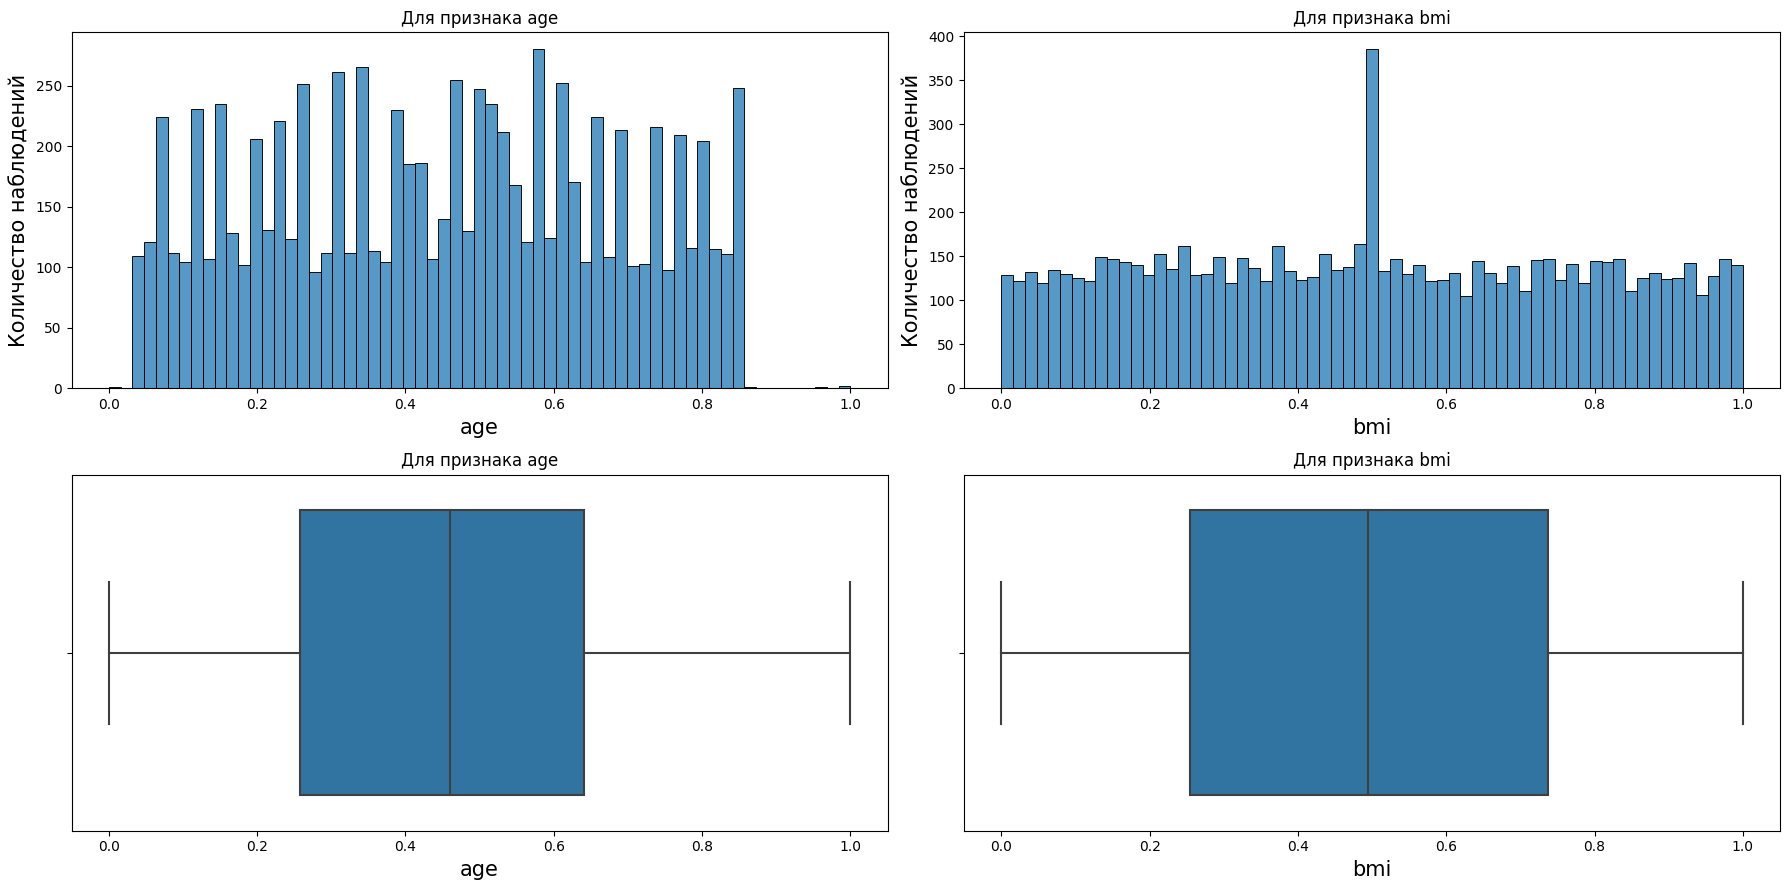

In [194]:
brief_for_digit (df, fisycal_col, df['id'])

Cтатистика по показателям:


,count,mean,std,min,25%,50%,75%,max
income,8685.0,0.496055,0.284698,0.0,0.251922,0.494889,0.741036,1.0
exercise_hours_per_week,8685.0,0.503378,0.284810,0.0,0.263286,0.502110,0.748709,1.0
sedentary_hours_per_day,8685.0,0.499164,0.285340,0.0,0.255875,0.499920,0.744623,1.0
sleep_hours_per_day,8685.0,0.503737,0.328061,0.0,0.166667,0.500000,0.833333,1.0


Визуализация
Гистограммы и диаграммы размаха


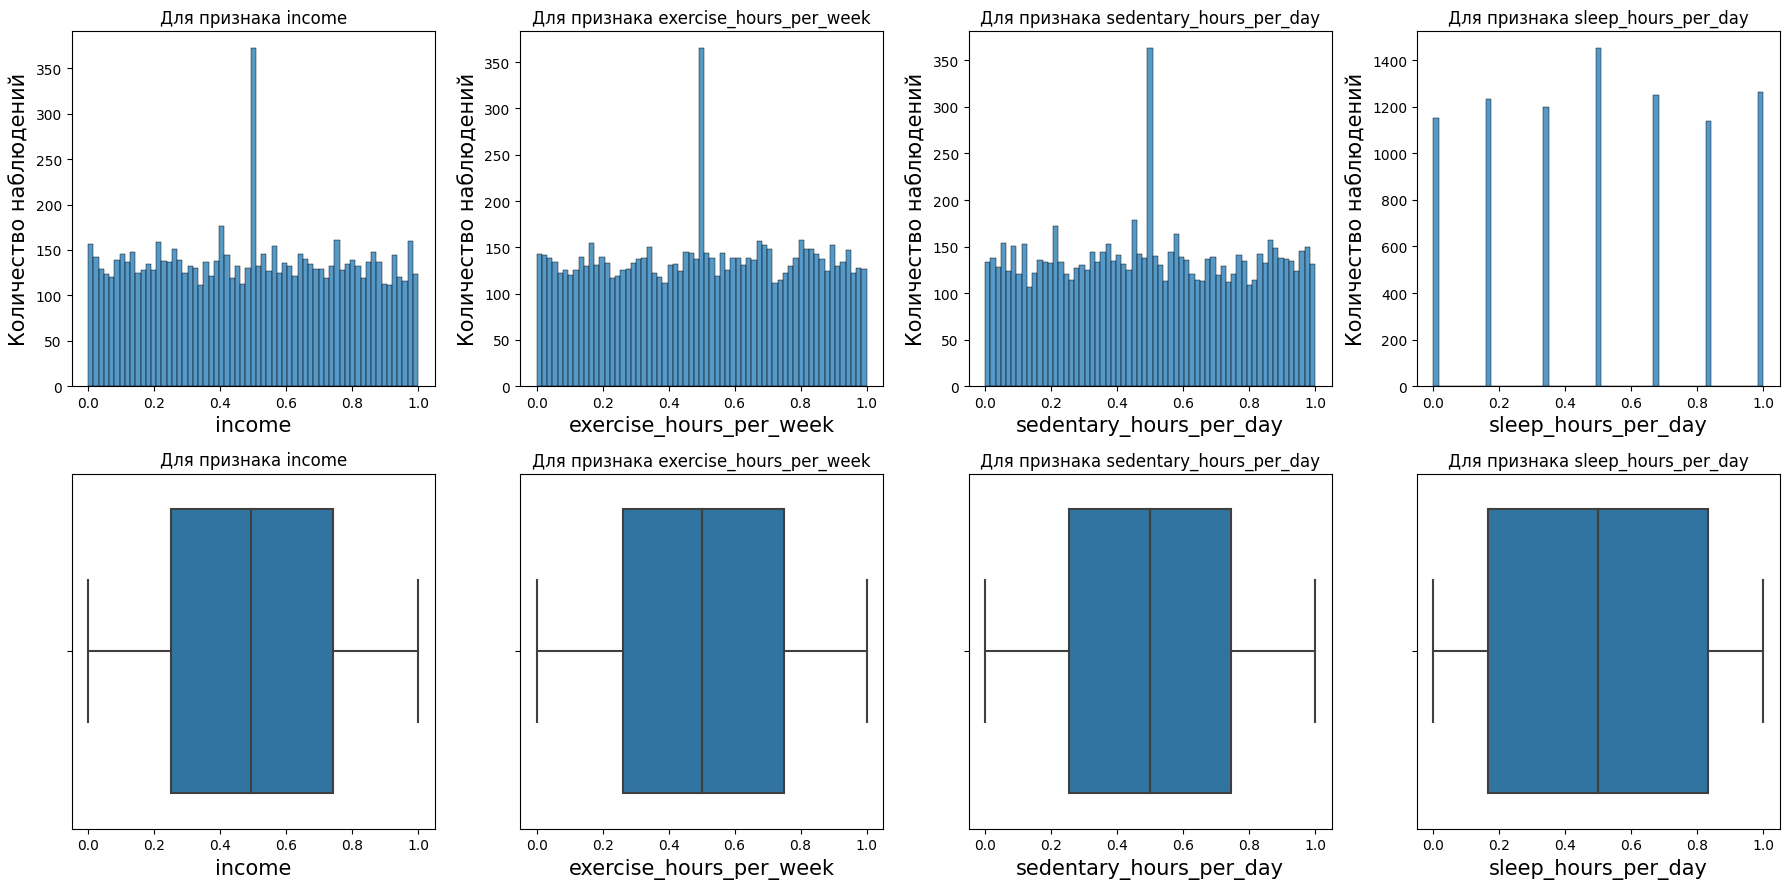

In [195]:
brief_for_digit (df, lifestyle_col, df['id'])

Cтатистика по показателям:


,count,mean,std,min,25%,50%,75%,max
cholesterol,8685.0,0.501070,0.284716,0.0,0.267857,0.499780,0.746429,1.0
triglycerides,8685.0,0.505484,0.286320,0.0,0.263636,0.503603,0.750649,1.0
blood_sugar,8685.0,0.227339,0.076635,0.0,0.227018,0.227018,0.227018,1.0
ck-mb,8685.0,0.048159,0.075531,0.0,0.048229,0.048229,0.048229,1.0
troponin,8685.0,0.036689,0.060157,0.0,0.036512,0.036512,0.036512,1.0


Визуализация
Гистограммы и диаграммы размаха


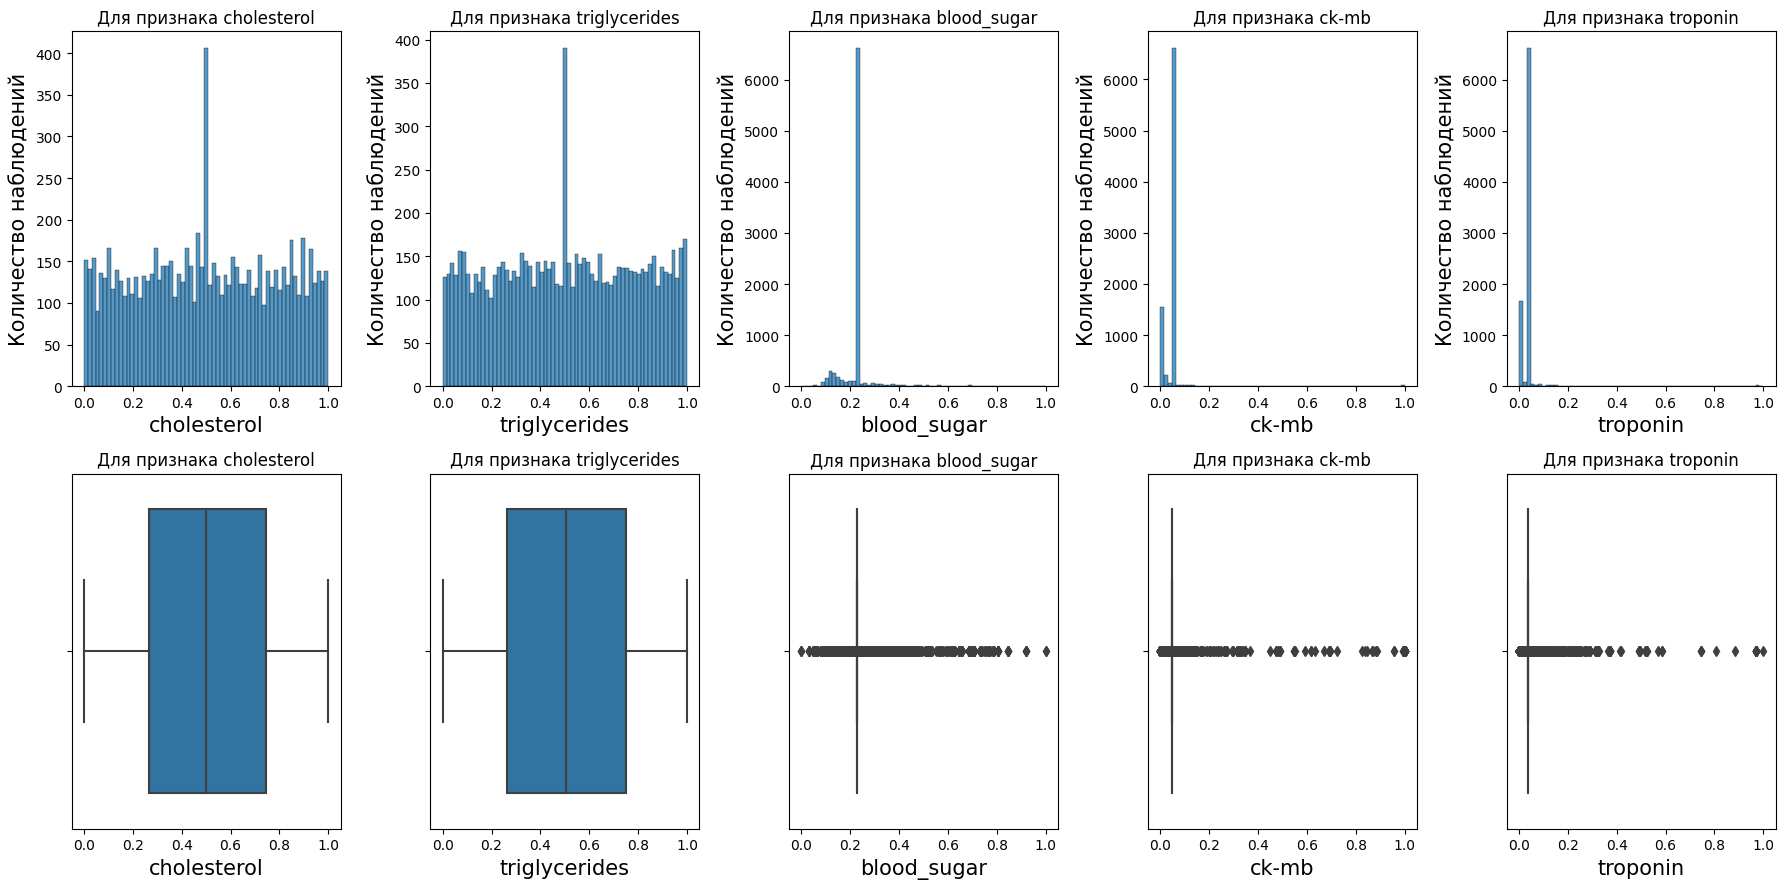

In [196]:
brief_for_digit (df, analysys_col, df['id'])

Cтатистика по показателям:


,count,mean,std,min,25%,50%,75%,max
heart_rate,8685.0,0.050658,0.023453,0.0,0.034830,0.050412,0.065995,1.0
systolic_blood_pressure,8685.0,0.450295,0.170184,0.0,0.303226,0.445161,0.600000,1.0
diastolic_blood_pressure,8685.0,0.497634,0.171830,0.0,0.348837,0.500000,0.651163,1.0


Визуализация
Гистограммы и диаграммы размаха


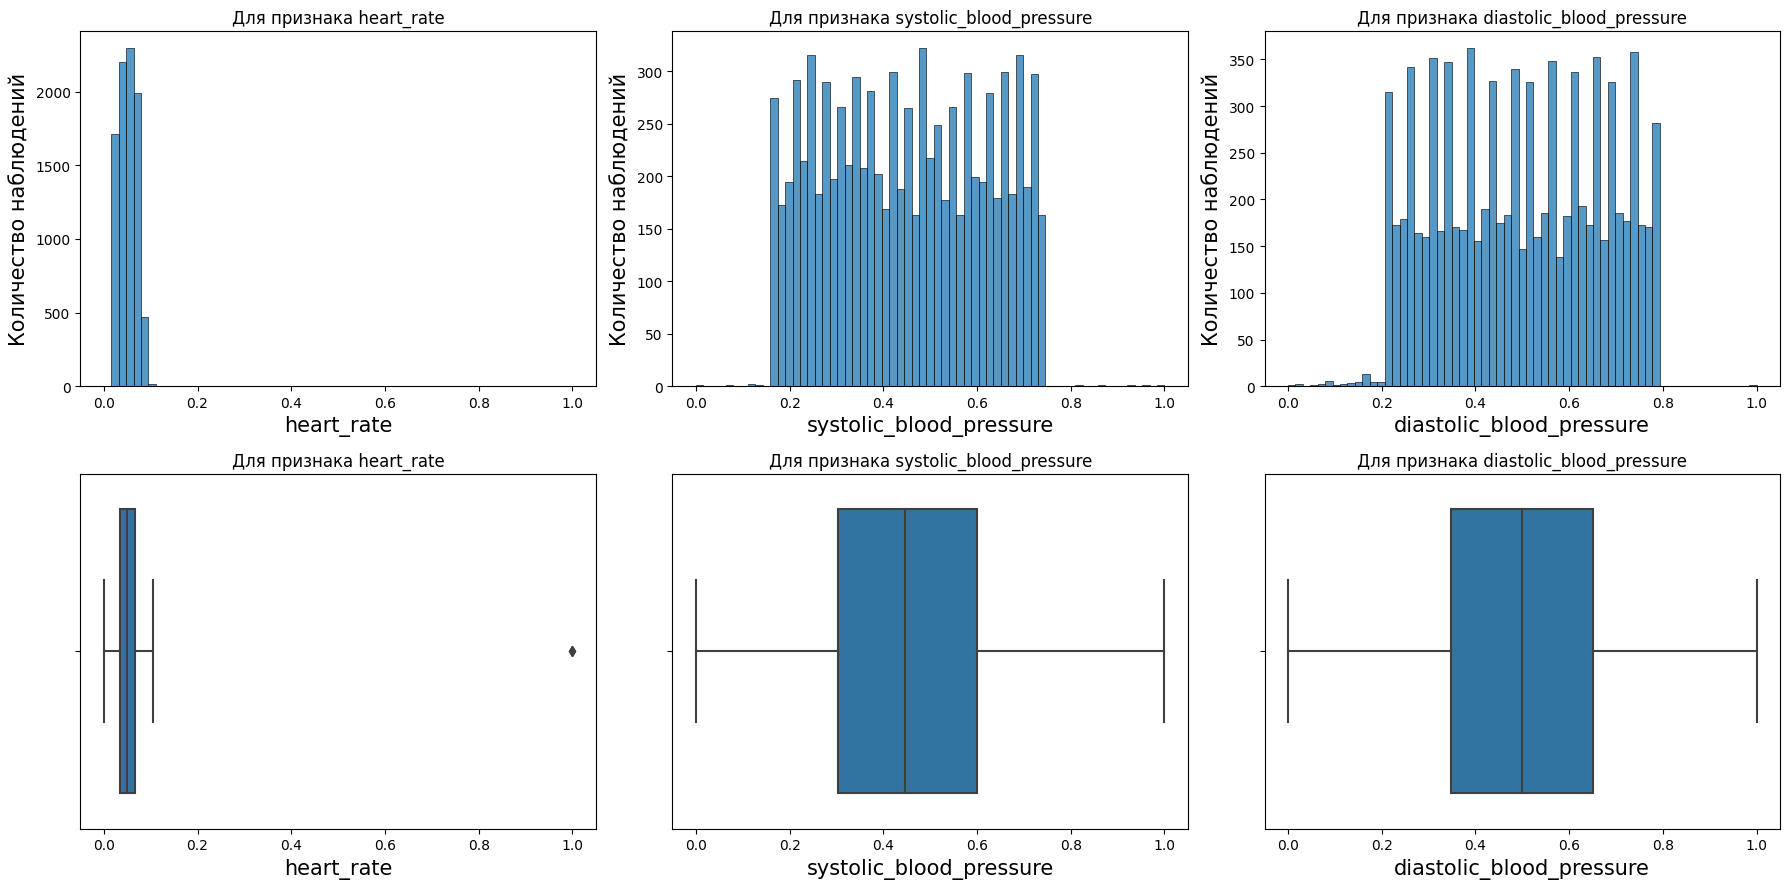

In [197]:
brief_for_digit (df, heart_col, df['id'])

Признак продолжительности сна имеет чёткое почти равномерное распредление по 7 значениям, и может быть переведен в категориальный.

*Аномалии*

В гистограммах дохода, физической активности и малоподвижности, массы тела (bmi), холестерола и триглигеридов обнаружены схожие аномалии.

в центре гистограммы (примерно на значении 0.5) наблюдается резкое увеличение количества наблюдений. 
Такая особенность может либо о наличии специфического значения в данных (например, результат округления, заполнение пропусков средним, особенностью шкалы), либо о технической ошибке при формировании переменной.

Например, 0.5 может быть результатом заполнения пропусков средним/медианой, дефолтным значением. 


### Работа с выбросами в числовых столбцах
#### Анализ строк с пропусками
Рассмотрим анамалию внимателно на примере показателя Доход.

Показатели в цифрах:


count    8685.000000
mean        0.496055
std         0.284698
min         0.000000
25%         0.251922
50%         0.494889
75%         0.741036
max         1.000000
Name: income, dtype: float64


 Визуализация показателей категории:


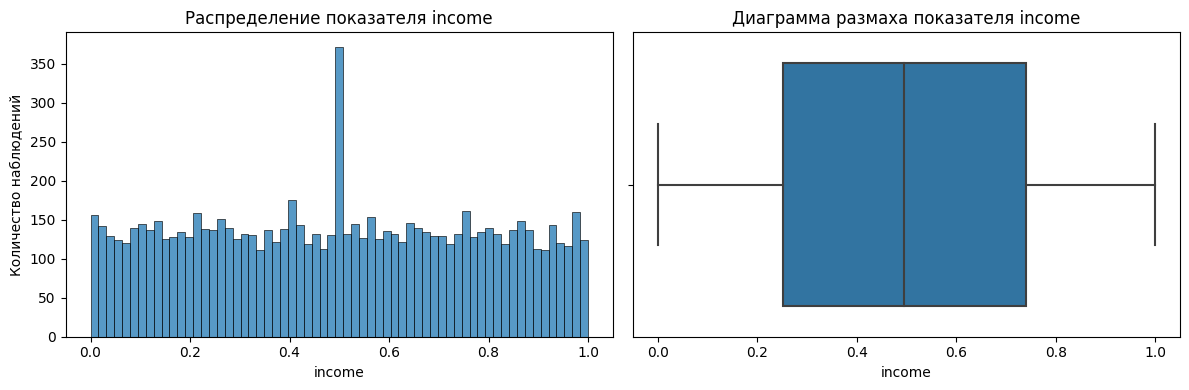

In [198]:

brief_for_1digit (df, df['income'], df['id'])

In [199]:
mode_value = df['income'].mode()[0]
percentage = (df['income'] == mode_value).mean() * 100
count_mode = (df['income'] == mode_value).sum()

print('Всего записей-выбросов',count_mode)
print(f"Мода: {mode_value}")
print(f"Процент записей с модой: {percentage:.2f}%")


Всего записей-выбросов 243
Мода: 0.4948894028003345
Процент записей с модой: 2.80%


На примере показателей дохода видно, что действительно, самое распространенное значение  0.494889 равное медианному 0.494889.
Скорее всего, здесь случай заполнения пропущенных значений медианнными показателями

In [200]:
display(df[df['income'] == mode_value])

,unnamed:_0,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
16,16,0.449438,0.49978,0.063245,-1,-1,-1,-1,-1,0.50211,3,-1,-1,-1,0.49992,0.494889,0.494774,0.503603,-1,0.504621,0.0,0.233202,0.026692,0.000777,1,0.393548,0.255814,9528
90,90,0.370787,0.49978,0.066911,-1,-1,-1,-1,-1,0.50211,3,-1,-1,-1,0.49992,0.494889,0.494774,0.503603,-1,0.504621,0.0,0.154150,0.004702,0.042043,1,0.258065,0.337209,9640
92,92,0.629213,0.49978,0.073327,-1,-1,-1,-1,-1,0.50211,3,-1,-1,-1,0.49992,0.494889,0.494774,0.503603,-1,0.504621,0.0,0.256917,0.012310,0.000777,0,0.258065,0.232558,9515
185,185,0.516854,0.49978,0.045830,-1,-1,-1,-1,-1,0.50211,3,-1,-1,-1,0.49992,0.494889,0.494774,0.503603,-1,0.504621,0.0,0.559289,0.006704,0.000291,0,0.174194,0.151163,9491
188,188,0.269663,0.49978,0.035747,-1,-1,-1,-1,-1,0.50211,3,-1,-1,-1,0.49992,0.494889,0.494774,0.503603,-1,0.504621,0.0,0.112648,0.051218,0.000485,0,0.225806,0.162791,9448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8461,8461,0.719101,0.49978,0.049496,-1,-1,-1,-1,-1,0.50211,3,-1,-1,-1,0.49992,0.494889,0.494774,0.503603,-1,0.504621,0.0,0.138340,0.004034,0.003204,1,0.548387,0.558140,9455
8509,8509,0.651685,0.49978,0.036664,-1,-1,-1,-1,-1,0.50211,3,-1,-1,-1,0.49992,0.494889,0.494774,0.503603,-1,0.504621,0.0,0.239130,0.055790,0.060783,1,0.729032,0.779070,9506
8536,8536,0.651685,0.49978,0.054079,-1,-1,-1,-1,-1,0.50211,3,-1,-1,-1,0.49992,0.494889,0.494774,0.503603,-1,0.504621,0.0,0.276680,0.008673,0.150403,1,0.606452,0.790698,9474
8619,8619,0.606742,0.49978,0.059578,-1,-1,-1,-1,-1,0.50211,3,-1,-1,-1,0.49992,0.494889,0.494774,0.503603,-1,0.504621,0.0,0.156126,0.057692,0.000583,0,0.387097,0.500000,9467


По датасету с выбранными записями выбросами по одному столбцу видно, что все такие аномальные записи относяися к записям с пропусками.
В дальнейгем записи могут быть удалены

#### Прочие выбросы

Также выбросы содержатся в столбцах heart_rate (частота сердечных сокращений) и blood_sugar (содержание сахара в крови)


Показатели в цифрах:


count    8685.000000
mean        0.050658
std         0.023453
min         0.000000
25%         0.034830
50%         0.050412
75%         0.065995
max         1.000000
Name: heart_rate, dtype: float64


 Визуализация показателей категории:


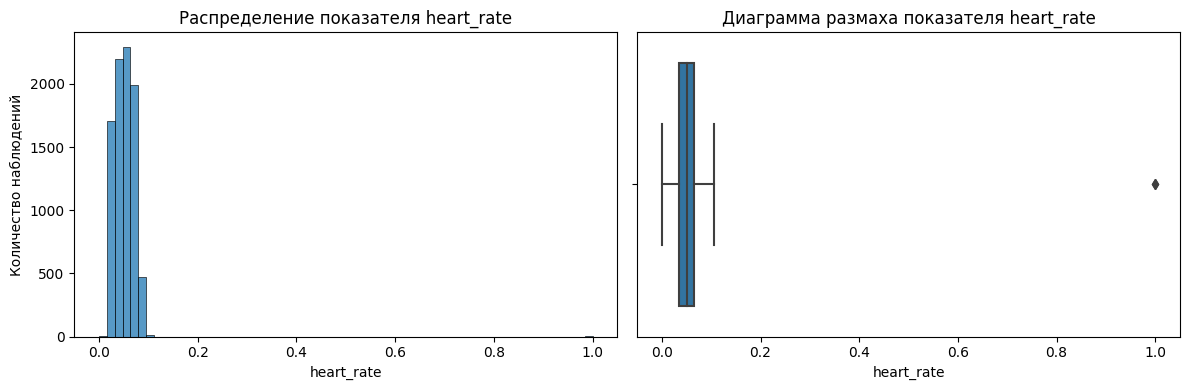

In [201]:
 brief_for_1digit (df, df['heart_rate'], df['id'])

In [202]:
display(df[df['heart_rate'] == 1])

,unnamed:_0,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
1377,1377,0.629213,0.49978,1.0,-1,-1,-1,-1,-1,0.50211,3,-1,-1,-1,0.49992,0.494889,0.494774,0.503603,-1,0.504621,0.0,0.203557,0.011843,0.002622,0,0.490323,0.616279,9547
2712,2712,0.202247,0.49978,1.0,-1,-1,-1,-1,-1,0.50211,3,-1,-1,-1,0.49992,0.494889,0.494774,0.503603,-1,0.504621,0.0,0.092885,0.007805,0.000680,0,0.490323,0.616279,9611


Выбросы содержаться всего в двух запиcях с id пациентов 9547 и 9611, они находятся в записях с пропусками. Предположительно ими можно принебречь при построении модели

In [203]:
df = df[~df['id'].isin([9547, 9611])]

Показатели в цифрах:


count    8683.000000
mean        0.227357
std         0.076630
min         0.000000
25%         0.227018
50%         0.227018
75%         0.227018
max         1.000000
Name: blood_sugar, dtype: float64


 Визуализация показателей категории:


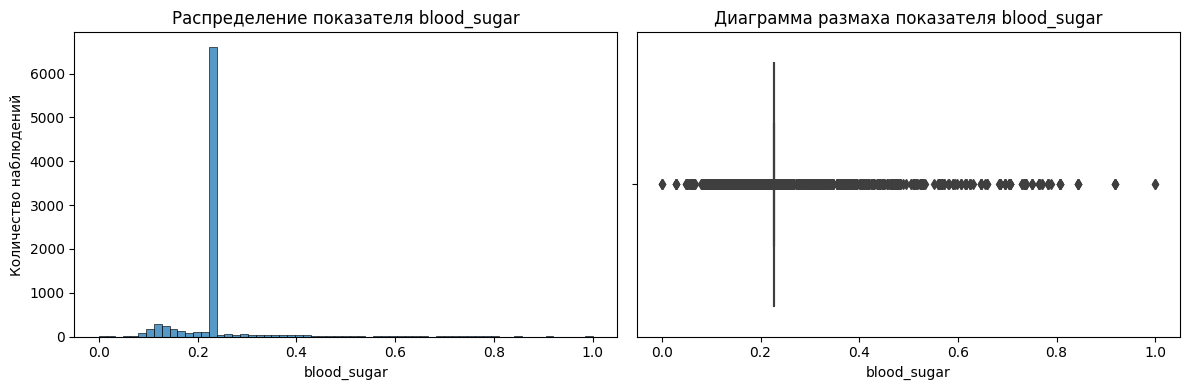

In [204]:
 brief_for_1digit (df, df['blood_sugar'], df['id'])

In [205]:
blood_mode = df["blood_sugar"].mode().iloc[0]
print(f'Наиболее часто встречающийся показатель (мода) {blood_mode:.2f}')
print(f'Медиана {df["blood_sugar"].median():.2f}')
print('Всего таких значений', df[df['blood_sugar'] == blood_mode]['id'].count())

Наиболее часто встречающийся показатель (мода) 0.23
Медиана 0.23
Всего таких значений 6551


Показатель сахара в крови 0.23 очень распространен (6551 значение). Возможно, он действительно часто встречаестся в нализах, также возможно такое значение ставится по умолчанию. В любом случае, данными записями нельзя принебречь

### Удаление пропусков

Эксперименально рассматриваем модель где некоторые стобцы категориальных данных могут не иметь значений  

### Анализ категориальных признаков

#### преобразование числовых и бинарных

В датасете только один признак категориальный  - формат диеты пациента.
Текущие бинарные и признкаки можно перевести в категориальные, некоторые можно рассматривать для моделирования как ординарные

In [206]:
for c in binary_columns:
    print(df[c].unique())

[1 0]
[ 1  0 -1]
[ 1  0 -1]
[ 1  0 -1]
[ 1  0 -1]
[ 1  0 -1]
[ 1  0 -1]
[ 0  1 -1]


Значение -1 обозначает отсутсвие данных. Экспериментально можно посмотреть возможности модели оценивать риск при отсуствующих данных, что может встречаться в медицинских показателях при первичных образениях пациентов

In [207]:
#перевод в категориальные бинарных столбцов
for cl in binary_columns:
    df.loc[:, cl] = df[cl].astype(object)


C:\DS\envs\practicum\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [208]:
#перевод в категориальные столбца с дискретными значениями (количество часов сна в день)
print(sorted(df['sleep_hours_per_day'].unique()))

[0.0, 0.1666666666666666, 0.3333333333333333, 0.4999999999999999, 0.5046212363584658, 0.6666666666666666, 0.8333333333333334, 1.0]


In [209]:
df.loc[:, 'sleep_hours_per_day'] = df['sleep_hours_per_day'].apply(
    lambda x: 'минимум' if x < 0.4 
    else ('достаточное' if x > 0.8 
    else 'удовлетворит')
)


In [210]:
print(sorted(df['sleep_hours_per_day'].unique()))

['достаточное', 'минимум', 'удовлетворит']


In [211]:
#аналогичное деление нак ктаегории со столбцами
# exercise_hours_per_week
# sedentary_hours_per_day
#'stress_level'
#'physical_activity_days_per_week'

df.loc[:, 'exercise_hours_per_week'] = df['exercise_hours_per_week'].apply( lambda x: 'минимум' if x < 0.2 
                                                            else ('достаточное' if x > 0.8
                                                            else 'удовлетворит'))  


In [212]:
df.loc[:, 'sedentary_hours_per_day'] = df['sedentary_hours_per_day'].apply( lambda x: 'минимум' if x < 0.2 
                                                            else ('чрезмерное' if x > 0.8
                                                            else 'среднее'))  

In [213]:
df.loc[:, 'stress_level'] = df['stress_level'].apply(
    lambda x: 'не указан' if x == -1 
    else 'низкий' if x <= 3 
    else 'высокий' if x >= 8 
    else 'средний'
)

In [214]:
df.loc[:, 'physical_activity_days_per_week'] = df['physical_activity_days_per_week'].apply(
    lambda x: 'не указан' if x == -1 
    else 'низкая' if x <= 1 
    else 'высокая' if x >= 5 
    else 'средняя'
)

In [215]:
#все категориальные столбцы после преобразования
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(cat_cols)

['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'exercise_hours_per_week', 'previous_heart_problems', 'medication_use', 'stress_level', 'sedentary_hours_per_day', 'physical_activity_days_per_week', 'sleep_hours_per_day', 'gender']


#### Визуализация данных

Условно разделим столбцы на по смыслу

In [216]:
#общие характеристики
common_col = ['gender', 'family_history', 'previous_heart_problems', 'medication_use', 'diabetes']

#образ жизни
life_col_1 = ['smoking', 'obesity',  'alcohol_consumption']

life_col_2 = ['exercise_hours_per_week',
            'stress_level', 'physical_activity_days_per_week', 
            'sleep_hours_per_day']

Показатели в цифрах:


,шт.,"Доля,%"
1,6038,69.54
0,2645,30.46


,шт.,"Доля,%"
0,4309,49.63
1,4133,47.60
-1,241,2.78


,шт.,"Доля,%"
0,4260,49.06
1,4182,48.16
-1,241,2.78


,шт.,"Доля,%"
1,4231,48.73
0,4211,48.50
-1,241,2.78


,шт.,"Доля,%"
1,5505,63.40
0,2937,33.82
-1,241,2.78


Визуализация наблюдений признаков


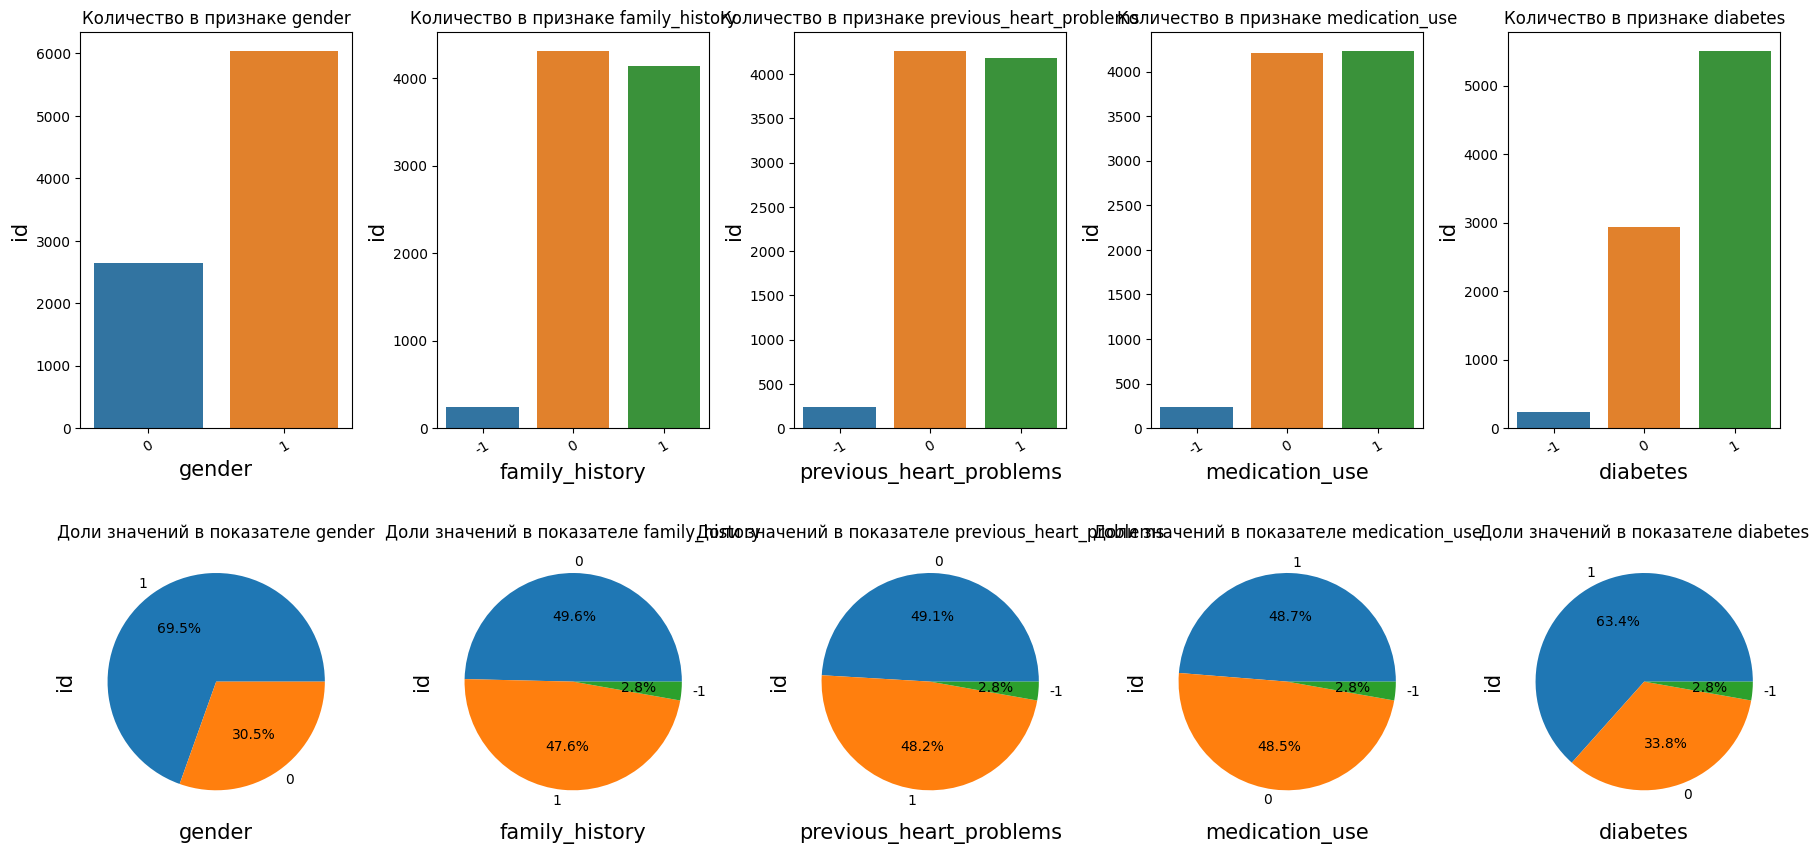

In [217]:
brief_for_cat (df, common_col, df['id'])

В датасете неравномерно представлено рапредение по гендеру (мужчин 69,5%)  и по налисию диабета (63,4%). Что может привести к смещениям оценки.

Показатели в цифрах:


,шт.,"Доля,%"
1,7622,87.78
0,820,9.44
-1,241,2.78


,шт.,"Доля,%"
0,4235,48.77
1,4207,48.45
-1,241,2.78


,шт.,"Доля,%"
1,5082,58.53
0,3360,38.70
-1,241,2.78


Визуализация наблюдений признаков


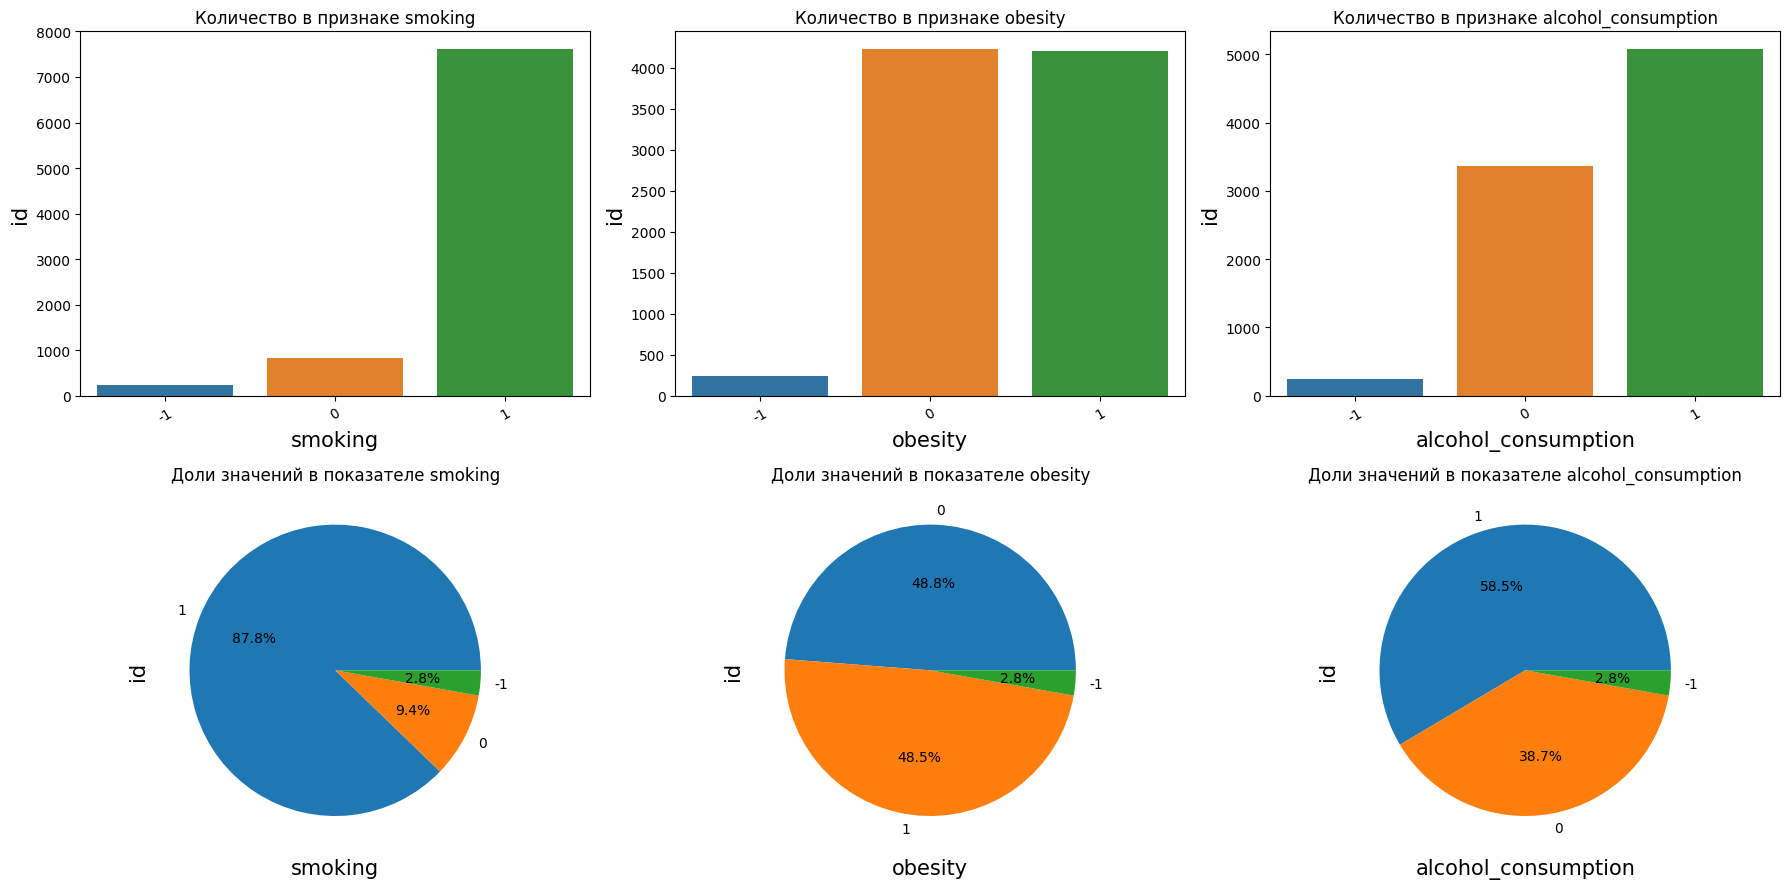

In [218]:
brief_for_cat (df, life_col_1, df['id'])

Очень большое смещение в датасете по показателю "курение" — 87.8%

Показатели в цифрах:


,шт.,"Доля,%"
удовлетворит,5244,60.39
достаточное,1744,20.09
минимум,1695,19.52


,шт.,"Доля,%"
средний,3387,39.01
низкий,2535,29.19
высокий,2520,29.02
не указан,241,2.78


,шт.,"Доля,%"
средняя,3203,36.89
высокая,3164,36.44
низкая,2075,23.90
не указан,241,2.78


,шт.,"Доля,%"
минимум,3584,41.28
удовлетворит,2701,31.11
достаточное,2398,27.62


Визуализация наблюдений признаков


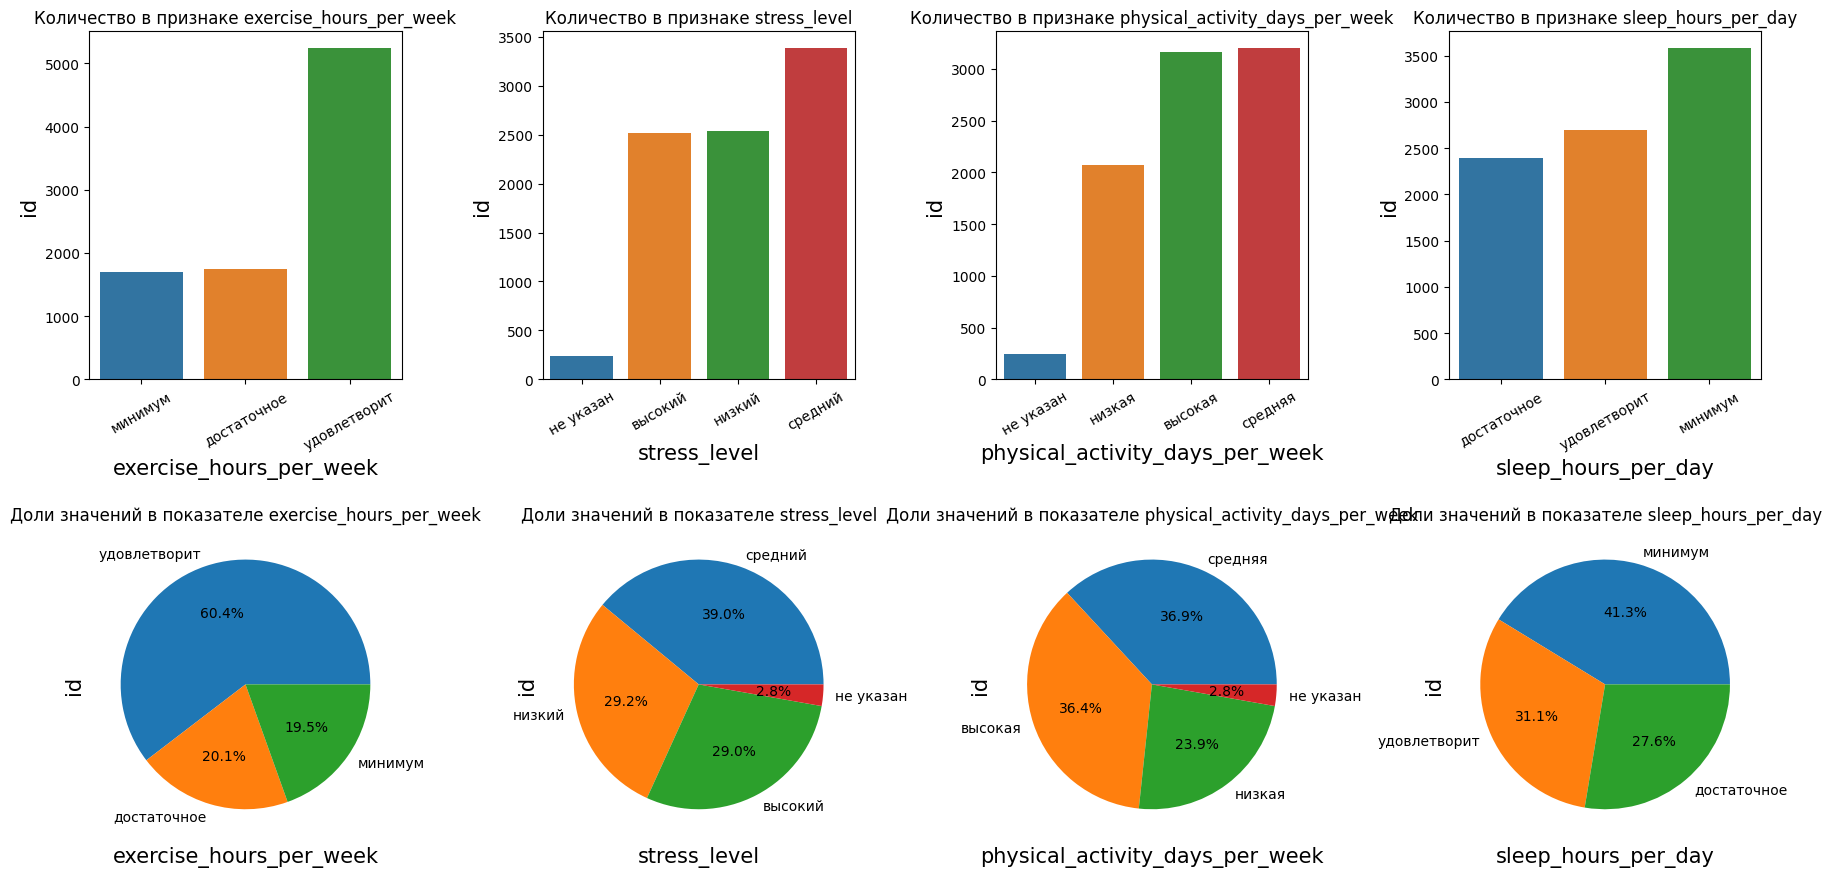

In [219]:
brief_for_cat (df, life_col_2, df['id'])

### Возможные утечки данных

При анализе предметной области были выявлены признаки, которые могут привести к утечке данных.

Два показателя могут приводить к утечке данных, т.к. Признаки, полученные из данных, которые становятся доступны только после наступления события целевой переменной.
При анализе сердечного приступа (инфаркта миокарда) косвенные утечки целевого признака могут проявляться через анализы и показатели, которые являются маркерами или следствиями самого события сердечного приступа:

* Сердечные тропонины (troponin I и T) — белки, высвобождающиеся из поврежденных клеток сердечной мышцы при инфаркте. Уровни тропонинов резко повышаются после приступа и служат прямыми биохимическими маркерами некроза миокарда.

* Креатинкиназа-МВ (CK-MB) — фермент, увеличивающийся в крови при повреждении сердечной мышцы, особенно после инфаркта.

Данные признаки лучше исключить при моделировании

## Анализ корреляции

### Матрица корреляции и её визуализация

In [220]:
corr_matrix = df.drop(['id','unnamed:_0'], axis= 1).phik_matrix()
print('Матрица корреляции.Коэффициент корреляции Фи')
display(corr_matrix)

interval columns not set, guessing: ['age', 'cholesterol', 'heart_rate', 'diet', 'income', 'bmi', 'triglycerides', 'heart_attack_risk_(binary)', 'blood_sugar', 'ck-mb', 'troponin', 'systolic_blood_pressure', 'diastolic_blood_pressure']
Матрица корреляции.Коэффициент корреляции Фи


,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure
age,1.000000,0.019698,0.079047,0.174501,0.172410,0.516217,0.176024,0.178247,0.000000,0.146640,0.175296,0.174028,0.142806,0.018876,0.026500,0.000000,0.078449,0.140512,0.039827,0.041449,0.362397,0.182924,0.120682,0.026816,0.341782,0.079065
cholesterol,0.019698,1.000000,0.177008,0.447283,0.446024,0.447065,0.446216,0.447940,0.069531,0.392997,0.445876,0.446369,0.396279,0.076969,0.192445,0.209397,0.203458,0.393607,0.147099,0.057001,0.088665,0.061531,0.028988,0.033955,0.084605,0.137081
heart_rate,0.079047,0.177008,1.000000,0.421984,0.421955,0.422691,0.423259,0.421542,0.053203,0.369772,0.422440,0.422279,0.368723,0.057376,0.183795,0.175578,0.179774,0.369116,0.120472,0.054313,0.364917,0.165989,0.193280,0.021419,0.123407,0.169860
diabetes,0.174501,0.447283,0.421984,1.000000,0.942874,0.942819,0.942858,0.942821,0.289485,0.676264,0.942830,0.942827,0.676285,0.286138,0.465480,0.456159,0.459205,0.676272,0.458656,0.074362,0.304071,0.154776,0.147657,0.005919,0.215082,0.577115
family_history,0.172410,0.446024,0.421955,0.942874,1.000000,0.942827,0.942841,0.942838,0.287716,0.676256,0.942819,0.942822,0.676315,0.287701,0.465868,0.456296,0.457557,0.676376,0.456799,0.073744,0.305814,0.155373,0.141976,0.007579,0.213019,0.577531
smoking,0.516217,0.447065,0.422691,0.942819,0.942827,1.000000,0.942819,0.942836,0.288459,0.676296,0.942820,0.942834,0.676261,0.285985,0.465022,0.456162,0.458782,0.676310,0.457209,0.073792,0.317764,0.155507,0.151098,0.303570,0.211610,0.577189
obesity,0.176024,0.446216,0.423259,0.942858,0.942841,0.942819,1.000000,0.942860,0.290746,0.676267,0.942828,0.942824,0.676370,0.285040,0.465230,0.455907,0.458179,0.676346,0.456561,0.074276,0.303844,0.155454,0.147192,0.005752,0.212082,0.577790
alcohol_consumption,0.178247,0.447940,0.421542,0.942821,0.942838,0.942836,0.942860,1.000000,0.288332,0.676286,0.942819,0.942831,0.676288,0.287290,0.465883,0.456165,0.458444,0.676305,0.456480,0.074237,0.304113,0.154293,0.143981,0.007568,0.211769,0.577248
exercise_hours_per_week,0.000000,0.069531,0.053203,0.289485,0.287716,0.288459,0.290746,0.288332,1.000000,0.100931,0.288329,0.291002,0.101307,0.000000,0.101637,0.063226,0.082151,0.101783,0.081653,0.005093,0.035106,0.016078,0.000000,0.000000,0.000000,0.085180
diet,0.146640,0.392997,0.369772,0.676264,0.676256,0.676296,0.676267,0.676286,0.100931,1.000000,0.676408,0.676308,0.895111,0.099533,0.412723,0.403324,0.406685,0.895252,0.187518,0.185808,0.259922,0.124881,0.081572,0.007941,0.177189,0.379072


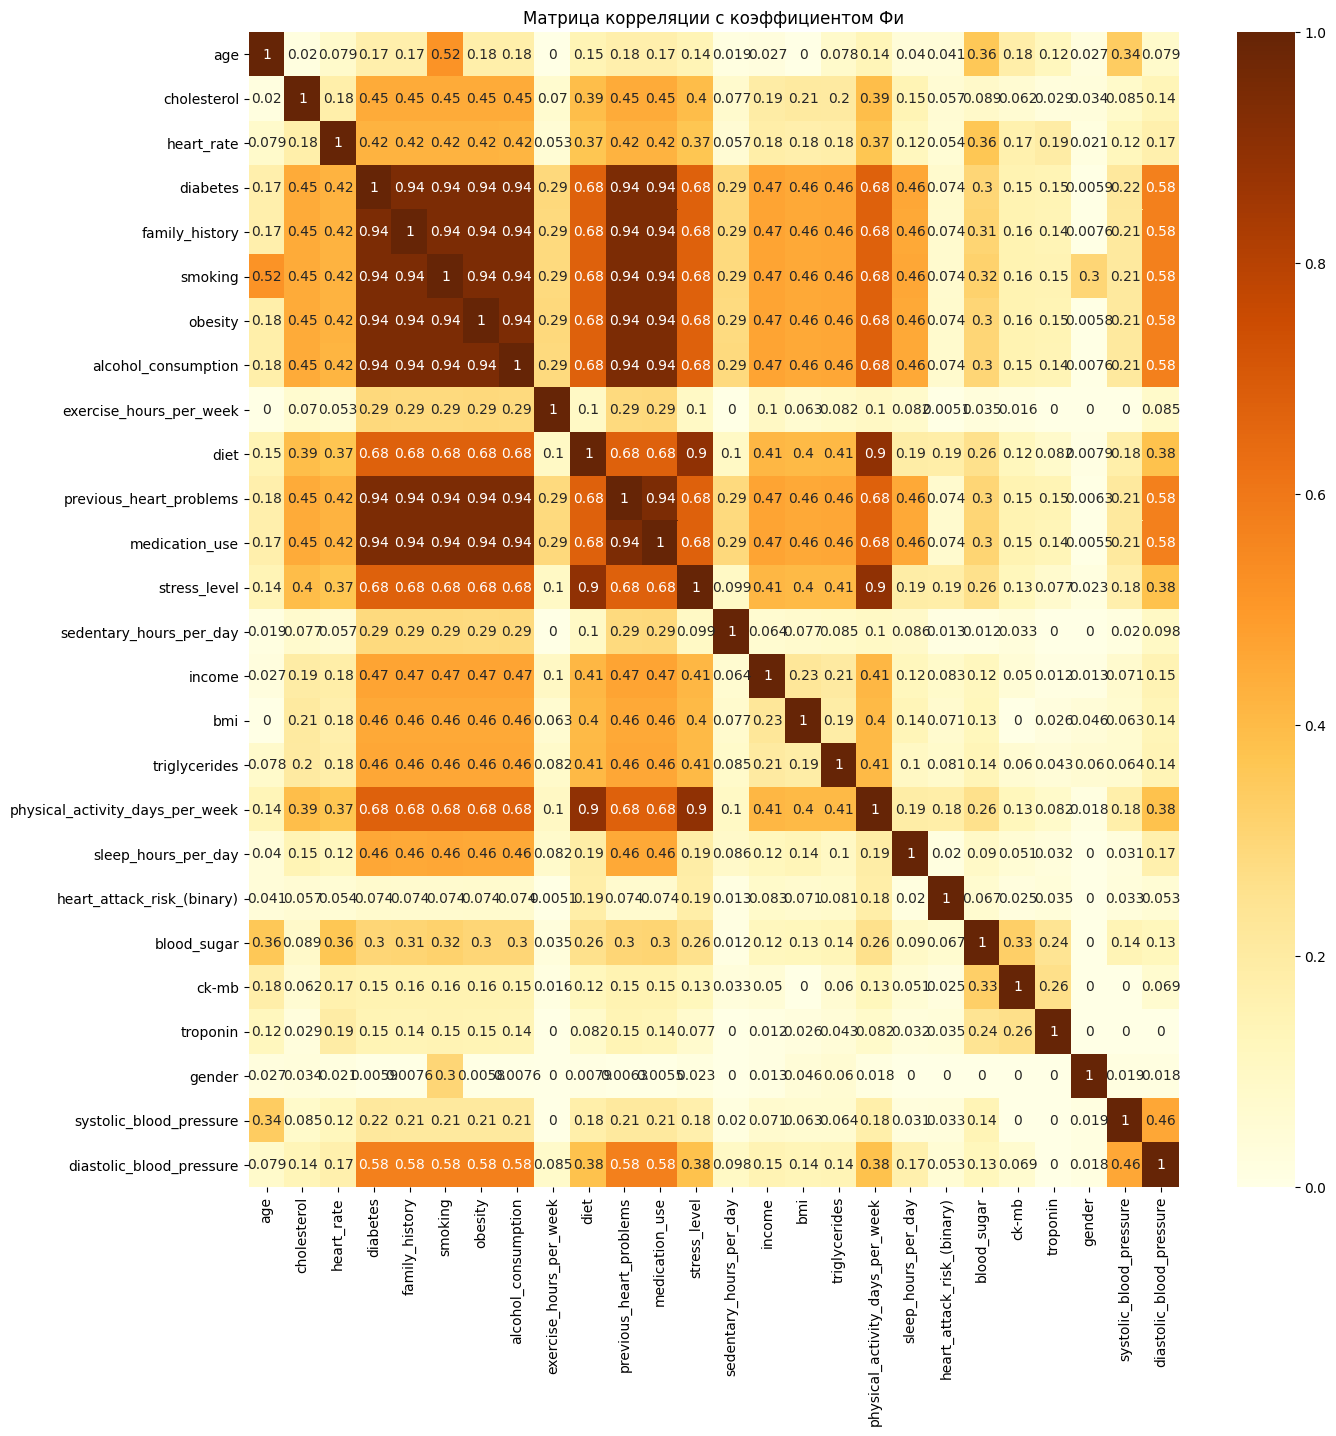

In [221]:
plt.figure(figsize=(15, 15))

sns.heatmap(corr_matrix, annot=True, cmap='YlOrBr')
plt.title('Матрица корреляции c коэффициентом Фи')
plt.show()

Между некоторыми признаками наблюдается мультиколлинеарность.
Сильные зависимости можно выявить в столбцах, характеризующих образ жизни (наличие диабета, наличие заболеваний у членов семьи, курение, потребление алкоголя и ожирение пациента, ранее выявленные проблемы с сердцем и потребление лекарств) - 0.94

Кроме того, признак BMI (массы тела) по смыслу дублирует признак "ожирение".


Возможно при моделировании от части этих признаков стоит отказаться. 
Предполагается оставить измериму  ретроспективная характеристика — наличие заболеваний сердца в прошлом.
Остальные коррелирующие столбцы можно исключить из анализа

Также сильна зависимость у показателей физической активности, уровня стресса и диеты - 0.9.
Оценка парметра уровень стресса может быть субъективной, да и диета пациента не всегда однозначно измерима.

Параметр "количество дней физической активности в неделю" более измеримая величина, для моделирования предлагается использовать его.


Стоит отметить, что с целевым признаком heart_attack_risk у большинства признаков корредяция выражена слабо.
Даже с подозреваемыми призанками 
С признаком "пол пациента" корреляция нулевая. Однако данный признак не исключаем, т.к. у него может быть нелинейная зависимость с другими признаками и он может оказаться полезным для модели


Кажется лишним социальный признак "Доход" (income)

### Итоговый набор признаков для моделированияв датасете

In [222]:
print(df.columns.tolist())

['unnamed:_0', 'age', 'cholesterol', 'heart_rate', 'diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'exercise_hours_per_week', 'diet', 'previous_heart_problems', 'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides', 'physical_activity_days_per_week', 'sleep_hours_per_day', 'heart_attack_risk_(binary)', 'blood_sugar', 'ck-mb', 'troponin', 'gender', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'id']


In [223]:
col_to_use = ['age', 'cholesterol', 'heart_rate', 
              'exercise_hours_per_week', 'previous_heart_problems', 
              'sedentary_hours_per_day', 'bmi', 'triglycerides',
              'physical_activity_days_per_week', 'sleep_hours_per_day', 
              'blood_sugar', 'gender', 'systolic_blood_pressure', 'diastolic_blood_pressure',
              'id','heart_attack_risk_(binary)']

In [224]:
col_exclude = ['diabetes', 
               'family_history',
               'smoking', 
               'obesity',
               'alcohol_consumption',
               'diet',
               'medication_use', 
               'stress_level',
               'ck-mb', 'troponin',
               'income'
                ]


#таргет 'heart_attack_risk_(binary)'


In [225]:
df_train = df[col_to_use].copy()
df_train = df_train.drop_duplicates()

## Подготовка тестовых данных

Тестовые данные потребуют то же преобразование форматов, что тренировочные

In [226]:
df_test['gender'] = df_test['gender'].apply(lambda x: 1 if x in ['Male', '1.0'] 
                            else (0 if x in ['Female', '0.0'] 
                            else np.nan))

In [227]:
c_ =['previous_heart_problems', 'sedentary_hours_per_day','physical_activity_days_per_week']
for col in c_:
    df_test[col] = df_test[col].fillna(-1).astype(int)


In [228]:
df_test['previous_heart_problems'] = df_test['previous_heart_problems'].astype(object)

In [229]:
df_test.loc[:, 'exercise_hours_per_week'] = df_test['exercise_hours_per_week'].apply( lambda x: 'минимум' if x < 0.2 
                                                                               else ('достаточное' if x > 0.8
                                                                               else 'удовлетворит'))  

df_test.loc[:, 'physical_activity_days_per_week'] = df_test['physical_activity_days_per_week'].apply(
    lambda x: 'не указан' if x == -1 
    else 'низкая' if x <= 1 
    else 'высокая' if x >= 5 
    else 'средняя'
)

df_test.loc[:, 'sleep_hours_per_day'] = df_test['sleep_hours_per_day'].apply( lambda x: 'минимум' if x < 0.4 
                                                            else ('достаточное' if x > 0.8
                                                            else 'удовлетворит'))

df_test.loc[:, 'sedentary_hours_per_day'] = df_test['sedentary_hours_per_day'].apply( lambda x: 'минимум' if x < 0.2 
                                                            else ('чрезмерное' if x > 0.8
                                                            else 'среднее'))  

In [230]:
#возможно из моделирования можно исключить 
#похожие по смыслу показатели физической активности

In [231]:
col_to_test = ['age',
               'cholesterol',
               'heart_rate',
 'exercise_hours_per_week',
 'previous_heart_problems',
 'sedentary_hours_per_day',
 'bmi',
 'triglycerides',
 'physical_activity_days_per_week',
 'sleep_hours_per_day',
 'blood_sugar',
 'gender',
 'systolic_blood_pressure',
 'diastolic_blood_pressure',
              'id']
df_test_ready = df_test[col_to_test].copy()

## Построение модели

### Подготовка данных

In [232]:
X = df_train.drop(['id', 'heart_attack_risk_(binary)'], axis=1)
y = df_train['heart_attack_risk_(binary)']

In [233]:

#деление на тестовую и валидационная
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y  
)

In [234]:
num_columns = X_train.select_dtypes(include='number').columns.tolist()
ohe_columns = ['gender','previous_heart_problems']
ord_columns = ['exercise_hours_per_week','sedentary_hours_per_day', 'physical_activity_days_per_week', 'sleep_hours_per_day']


print('\n Количественные признаки', num_columns)
print('\n Категориальные признаки', ohe_columns)
print('\n Порядковые  признаки', ord_columns)


 Количественные признаки ['age', 'cholesterol', 'heart_rate', 'bmi', 'triglycerides', 'blood_sugar', 'systolic_blood_pressure', 'diastolic_blood_pressure']

 Категориальные признаки ['gender', 'previous_heart_problems']

 Порядковые  признаки ['exercise_hours_per_week', 'sedentary_hours_per_day', 'physical_activity_days_per_week', 'sleep_hours_per_day']


In [237]:
# ohe_pipe = Pipeline(
#     [
#         (
#             'simpleImputer_ohe', 
#             SimpleImputer(missing_values=np.nan, strategy='most_frequent')
#         ),
#         (
#             'ohe', 
#             OneHotEncoder(drop='first', handle_unknown='ignore')
#         )
#     ]
# )

# ord_pipe = Pipeline(
#     [
#         (
#             'simpleImputer_before_ord', 
#             SimpleImputer(missing_values=np.nan, strategy='most_frequent')
#         ),
#         (
#             'ord',
#             OrdinalEncoder(
#                 categories=[
#                     ['среднее', 'чрезмерное', 'минимум'],  # Добавлены запятые
#                     ['средняя', 'низкая', 'высокая', 'не указан'],
#                     ['минимум', 'достаточное', 'удовлетворит'],
#                     ['стандарт', 'премиум']
#                 ], 
#                 handle_unknown='use_encoded_value',
#                 unknown_value=-1  # Изменено на целое число вместо np.nan
#             )
#         ),
#         (
#             'simpleImputer_after_ord', 
#             SimpleImputer(missing_values=-1, strategy='most_frequent')  # Соответствующее значение
#         )
#     ]
# )

In [239]:
# simple_preprocessor = ColumnTransformer(
#     [
#         ('num', 'passthrough', num_columns)
#     ], 
#     remainder='passthrough'
# )

# # Пайплайн с CatBoost
# pipe_final = Pipeline(
#     [
#         ('preprocessor', simple_preprocessor),
#         ('model', CatBoostClassifier(
#             random_state=RANDOM_STATE,
#             verbose=False,
#             cat_features=ohe_columns + ord_columns  
#         ))
#     ]
# )

In [240]:
#pipe_final.fit(X_train, y_train)

### Обучение

Для проекта экспериментально выбрана модель CatBoost, по следующим причинам:
* Большое количество категориальных данных
* Работа с дисбалансом классов, при исследовании вероятно, больных людей будет выявляться меньше, чем здоровых
* Модель характеризуют как устойчивую к переобучению и выбросам



In [248]:

cat_columns = ohe_columns + ord_columns


# Обучение CatBoost напрямую (модель сама кодирует признаки)
model = CatBoostClassifier(
     auto_class_weights='Balanced',
    scale_pos_weight=class_ratio,
    random_state=RANDOM_STATE,
    verbose=False,
    cat_features=cat_columns
)

model.fit(X_train, y_train)

In [242]:
print(model.get_all_params())

{'nan_mode': 'Min', 'eval_metric': 'Logloss', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'], 'iterations': 1000, 'sampling_frequency': 'PerTree', 'fold_permutation_block': 0, 'leaf_estimation_method': 'Newton', 'random_score_type': 'NormalWithModelSizeDecrease', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'ctr_leaf_count_limit': 18446744073709551615, 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'max_ctr_complexity': 4, 'model_size_reg': 0.5, 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCo

In [249]:
#проверка на валидационной выборке
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)


In [250]:
# Оценка качества
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall (Sensitivity):", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred)) 

specificity = recall_score(y_test, y_pred, pos_label=0)
print(f"Specificity: {specificity:.4f}")

Accuracy: 0.5877950489349453
Recall (Sensitivity): 0.4427860696517413
Precision: 0.4126738794435858
Specificity: 0.6649


Оценка качества проводилась несколькими метриками.
Основная метрика Specifity (вычисляет долю правильно распознанных отрицательных объектов (специфичность))
Т.е. специфичность показывает, как хорошо модель распознаёт "здоровых" людей.

Результаты плохие, всего 66,4%. Нужна дополнительная настройка параметров модели и больше тестов.

## Выгрузка результатов

### Предсказание на тестовой выборке и выгрузка в csv формат

In [258]:
result_pred = model.predict(df_test_ready)

In [259]:

result_df = pd.DataFrame({
    'id': df_test_ready['id'],
    'prediction': result_pred
})

# 
result_df.to_csv('predictions.csv', index=False)

### Выгрузка модели для приложения

In [257]:
#
with open('catboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)